## Funciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def Leer_Datos(path, separator=',', only_cols=[], head=None, mapdict={}):   
    data = pd.read_csv(path, sep=separator)

    # Mantener solo las columnas a utilizar
    if only_cols:
        data = data[only_cols]

    # Reemplazar valores str 'yes'/ 'no'
    data = data.replace(mapdict)

    # Eliminar filas con nan
    data = data.dropna()
    return  data.values

def Normalizar_Datos(array):
    tmp = np.array(array[:,-1])
    p = np.mean(array, axis=0)
    d = np.std(array, axis=0)
    for i in range(0, array.shape[0]):
        array[i] = np.true_divide((array[i] - p), d)
    array[:,-1] = tmp[:]
    return array

def Sigmodial(X, theta):
    # Calculamos Y
    h = X.dot(theta.T)

    # 1 / (1 + e^(-y))
    z = 1 /(1 + np.exp(- h))
    return z

def Calcular_costo(X,Y,theta):
    tam = len(X)
    h = (Sigmodial(X,theta))
    a = np.log(h) * Y
    b = np.log(1 - h)*(1-Y)
    costo = np.sum(a+b) * (-1 / tam)
    return costo

def Gradiente(X,Y,theta):
    tam = len(X)
    hipotesis = Sigmodial(X,theta)
    resta = hipotesis - Y
    derivada = np.dot(X.T, resta) / tam
    return derivada

def Gradiente_descendiente(X,Y,theta,iteraciones,tasa):
    costos = [0]*iteraciones
    for i in range(iteraciones):
        derivada = Gradiente(X,Y,theta)
        theta = theta - (tasa * derivada).T
        costos[i] = Calcular_costo(X,Y,theta)
    return theta, costos

def Accuracy(X,Y,theta):
    y_p = np.rint(Sigmodial(X,theta))
    cont = 0
    for i in (Y - y_p):
        if(i == 0):
            cont = cont+1
    porcentaje = (cont/len(Y))*100
    return porcentaje

# Funciones k folds
def count_classes(data):
    class1 = []
    class2 = []
    total = 0
    for row in data:
        if row[-1] == True:
            class1.append(row)
        if row[-1] == False:
            class2.append(row)
        total += 1
    return total, class1, class2

def Crear_k_folds(data, k):
    total, class1, class2 = count_classes(data)
    print('Crear k folds: ', k)
    print('total: ', total, ' clase1: ', len(class1), ' clase2: ', len(class2))
    folds_class1 = np.array_split(class1, k)
    folds_class2 = np.array_split(class2, k)
    results = [0]*k
    for i in range(k):
        results[i] = np.concatenate((folds_class1[i], folds_class2[i]))
        ret = count_classes(results[i])
        print('fold #', i, ' total elementos: ', ret[0], ' clase1: ', len(ret[1]), ' clase2: ', len(ret[2]))

    return results

def Crear_Conjuntos(folds, i):
    test = folds[i]
    train = np.array([])
    for it in range(len(folds)):
        if it != i:
            # train = np.concatenate((train, folds[it]))
            if len(train) == 0:
                train = folds[it]
            else:
                train = np.concatenate((train, folds[it]))
  
    return test, train

## Experimentos

#### Conjunto 1 - Clima Australia

In [ ]:
# Conjunto 1 - Clima Australia
data = Leer_Datos(
    'https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/weatherAUS.csv',
    ',',
    ['MinTemp', 'MaxTemp', 'RainToday', 'RainTomorrow'],
    0,
    {'RainToday': {'Yes': 1, 'No': 0}, 'RainTomorrow': {'Yes': 1, 'No': 0}}
)

data = Normalizar_Datos(data)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)
    
        print('learning_rate ', lr, ' done')

    print(param_table)


param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

print('=========== Resultados - Conjunto 1 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.min())  # hallar indices de elemento minimo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Minimo: ', param_table.min())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])




Crear k folds:  3
total:  140086  clase1:  31054  clase2:  109032
fold # 0  total elementos:  46696  clase1:  10352  clase2:  36344
fold # 1  total elementos:  46695  clase1:  10351  clase2:  36344
fold # 2  total elementos:  46695  clase1:  10351  clase2:  36344
learning_rate  0  done
learning_rate  1  done
learning_rate  2  done
learning_rate  3  done
learning_rate  4  done
learning_rate  5  done
[[80.2509851  80.33878705 80.31737194 80.31523043 80.26169265 80.2509851
  80.25955114]
 [80.26169265 80.17174919 80.16318314 80.1738907  80.17817372 80.18888127
  80.18673976]
 [80.17174919 80.1738907  80.18888127 80.19530581 80.19958883 80.1931643
  80.19530581]
 [80.1738907  80.19530581 80.1931643  80.19744732 80.19744732 80.19744732
  80.19744732]
 [80.19102279 80.1931643  80.19744732 80.19744732 80.19744732 80.19744732
  80.19744732]
 [80.19530581 80.19744732 80.19744732 80.19744732 80.19744732 80.19744732
  80.19744732]]
learning_rate  0  done
learning_rate  1  done
learning_rate  2  d

In [ ]:
pd.set_option("display.max_rows", None, "display.max_columns", None)
print('=========== Resultados - Conjunto 1 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.min())  # hallar indices de elemento minimo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Minimo: ', param_table.min())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])

    


=========== Resultados - Conjunto 1 ==========
           500        1000       1500       2000       2500       3000  \
0.01  79.092121  79.560407  79.775277  79.827388  79.841666  79.870220   
0.05  79.841666  79.895919  79.899488  79.920904  79.935895  79.951599   
0.10  79.895919  79.920904  79.951599  79.964449  79.965163  79.969446   
0.20  79.920904  79.964449  79.970160  79.972301  79.972301  79.972301   
0.30  79.951599  79.970160  79.972301  79.972301  79.972301  79.972301   
0.40  79.964449  79.972301  79.972301  79.972301  79.972301  79.972301   

           3500  
0.01  79.905912  
0.05  79.956596  
0.10  79.971587  
0.20  79.972301  
0.30  79.972301  
0.40  79.972301  
================ Parámetros ==================
Minimo:  79.09212084816293
Learning rate:  0.01
Iterations:  500


Crear k folds:  3
total:  140086  clase1:  31054  clase2:  109032
fold # 0  total elementos:  46696  clase1:  10352  clase2:  36344
fold # 1  total elementos:  46695  clase1:  10351  clase2:  36344
fold # 2  total elementos:  46695  clase1:  10351  clase2:  36344


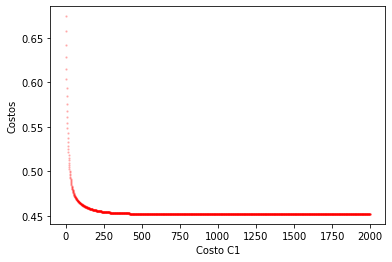

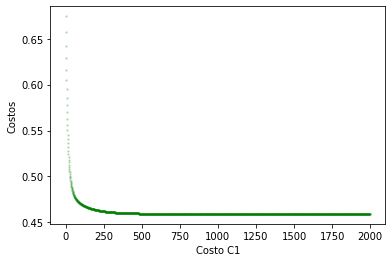

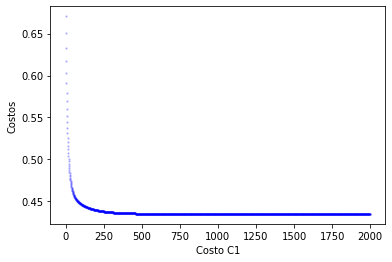

In [6]:
#Experimento 2
data = Leer_Datos(
    'https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/weatherAUS.csv',
    ',',
    ['MinTemp', 'MaxTemp', 'RainToday', 'RainTomorrow'],
    0,
    {'RainToday': {'Yes': 1, 'No': 0}, 'RainTomorrow': {'Yes': 1, 'No': 0}}
)

data = Normalizar_Datos(data)
folds = Crear_k_folds(data, 3)
colors = ["red","green","blue"]
k = 3
for i in range(k):
    train_set_1, test_set_1 = Crear_Conjuntos(folds, i)
    train_1_x, train_1_y  = train_set_1[:, 0:-1], train_set_1[:, -1:]

    train_1_x = np.insert(train_1_x, 0, 1, axis=1)

    thetas_1 = np.zeros(train_1_x.shape[1])[np.newaxis]

    # _, costos_1 = Gradiente_descendiente(train_1_x, train_1_y, thetas_1, 500, 0.01)
    _, costos_1 = Gradiente_descendiente(train_1_x, train_1_y, thetas_1, 2000, 0.2)
    plt.scatter(np.arange(2000), costos_1, alpha=0.2, c=colors[i], s=2)
    plt.xlabel('iteraciones')
    plt.ylabel('Costos')
    plt.xlabel('Costo C1')
    plt.show()
  

#### Conjunto 2 - Titanic

In [10]:
# Procesar datos
pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 5)
file1 = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/titanic_test.csv')
file2 = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/titanic_train.csv')
ids = pd.read_csv('https://raw.githubusercontent.com/agublazer/topicosia/master/practica2/data/gender_submission.csv')

# Unir conjunto de test con atributo Survived
file1 = pd.concat([file1, ids], axis=1, join="inner")

# Quitar atributos innecesarios y unir ambos archivos
file1 = file1[['Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
file2 = file2[['Sex', 'Age', 'Fare', 'Embarked', 'Survived']]
full_df = pd.concat([file1, file2])

mapdict = {'Embarked': {'Q': 0, 'S': 1, 'C': 2}, 'Sex': {'male': 1, 'female': 0}}
full_df = full_df.replace(mapdict)

full_df = full_df.dropna()
print(full_df)
print(full_df.Survived.unique())
print(full_df.Embarked.unique())
print(full_df.Sex.unique())

full_df = full_df.values


     Sex   Age     Fare  Embarked  Survived
0      1  34.5   7.8292       0.0         0
1      0  47.0   7.0000       1.0         1
2      1  62.0   9.6875       0.0         0
3      1  27.0   8.6625       1.0         0
4      0  22.0  12.2875       1.0         1
..   ...   ...      ...       ...       ...
885    0  39.0  29.1250       0.0         0
886    1  27.0  13.0000       1.0         0
887    0  19.0  30.0000       1.0         1
889    1  26.0  30.0000       2.0         1
890    1  32.0   7.7500       0.0         0

[1043 rows x 5 columns]
[0 1]
[0. 1. 2.]
[1 0]


In [ ]:
data = Normalizar_Datos(full_df)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)
    
        print('learning_rate ', lr, ' done')

    print(param_table)


param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 2 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.min())  # hallar indices de elemento minimo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Minimo: ', param_table.min())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])




Crear k folds:  3
total:  1043  clase1:  415  clase2:  628
fold # 0  total elementos:  349  clase1:  139  clase2:  210
fold # 1  total elementos:  347  clase1:  138  clase2:  209
fold # 2  total elementos:  347  clase1:  138  clase2:  209
learning_rate  0  done
learning_rate  1  done
learning_rate  2  done
learning_rate  3  done
learning_rate  4  done
learning_rate  5  done
[[94.55587393 94.84240688 94.84240688 94.55587393 94.26934097 94.26934097
  94.26934097]
 [94.26934097 94.26934097 94.26934097 94.26934097 94.26934097 94.26934097
  94.26934097]
 [94.26934097 94.26934097 94.26934097 94.26934097 94.26934097 94.26934097
  94.26934097]
 [94.26934097 94.26934097 94.26934097 94.26934097 94.26934097 94.26934097
  94.26934097]
 [94.26934097 94.26934097 94.26934097 94.26934097 94.26934097 94.26934097
  94.26934097]
 [94.26934097 94.26934097 94.26934097 94.26934097 94.26934097 94.26934097
  94.26934097]]
learning_rate  0  done
learning_rate  1  done
learning_rate  2  done
learning_rate  3  d

Crear k folds:  3
total:  1043  clase1:  415  clase2:  628
fold # 0  total elementos:  349  clase1:  139  clase2:  210
fold # 1  total elementos:  347  clase1:  138  clase2:  209
fold # 2  total elementos:  347  clase1:  138  clase2:  209


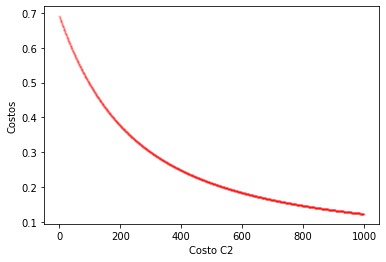

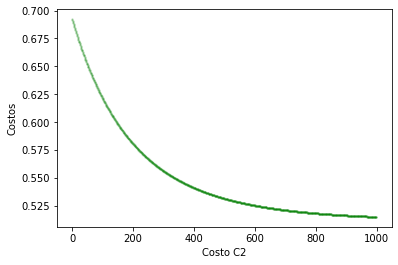

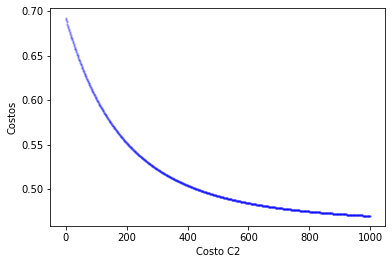

In [11]:
data = Normalizar_Datos(full_df)
folds = Crear_k_folds(data, 3)
k = 3
for i in range(k):
    train_set_2, test_set_2 = Crear_Conjuntos(folds, i)
    train_2_x, train_2_y  = train_set_2[:, 0:-1], train_set_2[:, -1:]

    train_2_x = np.insert(train_2_x, 0, 1, axis=1)

    thetas_2 = np.zeros(train_2_x.shape[1])[np.newaxis]

    _, costos_2 = Gradiente_descendiente(train_2_x, train_2_y, thetas_2, 1000, 0.01)
    plt.scatter(np.arange(1000), costos_2, alpha=0.2, c=colors[i], s=2)
    plt.xlabel('iteraciones')
    plt.ylabel('Costos')
    plt.xlabel('Costo C2')
    plt.show()
  

#### Conjunto 3 - sklearn

##### Enfoque uno vs todos

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine()

# Preparar dataset
data1 = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

print(data1.target.unique())



[0. 1. 2.]


In [ ]:
# Modelo 1 - 0 y [1, 2]
mapdict = {'target':{1:1, 2:1}}
dataset1 = data1.replace(mapdict)

# Modelo 2 - 1 y [0, 2]
mapdict = {'target':{0:0, 2:0}}
dataset2 = data1.replace(mapdict)

# Modelo 3 - 2 y [0, 1]
mapdict = {'target':{0:0, 1:0, 2:1}}
dataset3 = data1.replace(mapdict)

# Modelo 1 
data = Normalizar_Datos(dataset1.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 3 - 0 y [1, 2] ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento minimo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Máximo: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])


# Modelo 2
data = Normalizar_Datos(dataset2.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 2 - 1 y [0, 2] ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento minimo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Minimo: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])


# Modelo 3 
data = Normalizar_Datos(dataset3.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 3 - 2 y [0, 1] ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento maximo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Max: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])

Crear k folds:  3
total:  150  clase1:  100  clase2:  50
fold # 0  total elementos:  51  clase1:  34  clase2:  17
fold # 1  total elementos:  50  clase1:  33  clase2:  17
fold # 2  total elementos:  49  clase1:  33  clase2:  16
=========== Resultados - Conjunto 3 - 0 y [1, 2] ==========
       500    1000   1500   2000   2500   3000   3500
0.01  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.05  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.10  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.20  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.30  100.0  100.0  100.0  100.0  100.0  100.0  100.0
0.40  100.0  100.0  100.0  100.0  100.0  100.0  100.0
================ Parámetros ==================
Máximo:  100.0
Learning rate:  0.01
Iterations:  500
Crear k folds:  3
total:  150  clase1:  50  clase2:  100
fold # 0  total elementos:  51  clase1:  17  clase2:  34
fold # 1  total elementos:  50  clase1:  17  clase2:  33
fold # 2  total elementos:  49  clase1:  16  clase2:  33
======

##### Enfoque uno vs uno

In [ ]:
from sklearn.datasets import load_wine

wine = load_wine()

# Preparar dataset
data1 = pd.DataFrame(data= np.c_[wine['data'], wine['target']],
                     columns= wine['feature_names'] + ['target'])

print(data1.target.unique())

[0. 1. 2.]


In [ ]:
# Modelo 1 - 0 y 1
dataset1 = data1[data1.target != 2]
# Modelo 2 - 1 y 2
dataset2 = data1[data1.target != 0]
dataset2 = dataset2.replace({'target': {2: 0}})
# Modelo 3 - 0 y 2
dataset3 = data1[data1.target != 1]
dataset3 = dataset3.replace({'target': {2: 0}})

# Modelo 1 
data = Normalizar_Datos(dataset1.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 3 - 0 y 1 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento maximo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Max: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])

# Modelo 3
data = Normalizar_Datos(dataset3.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 3 - 1 y 2 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento maximo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Max: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])

# Modelo 3 
data = Normalizar_Datos(dataset3.values)
folds = Crear_k_folds(data, 3)

iterations = [500, 1000, 1500, 2000, 2500, 3000, 3500]
learning_rate = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4]
k = 3

param_shape = (len(learning_rate),len(iterations))
param_table = np.zeros(param_shape)

for i in range(k):
    test_set, train_set = Crear_Conjuntos(folds, i)
    train_x, train_y  = train_set[:, 0:-1], train_set[:, -1:]
    test_x, test_y =  test_set[:, 0:-1], test_set[:, -1:]
     
    train_x = np.insert(train_x, 0, 1, axis=1)
    test_x = np.insert(test_x, 0, 1, axis=1)
    thetas = np.zeros(train_x.shape[1])[np.newaxis]

    for lr in range(len(learning_rate)):
        for it in range(len(iterations)):
            theta_actual, _ = Gradiente_descendiente(train_x, train_y, thetas, iterations[it], learning_rate[lr])
            param_table[lr, it] += Accuracy(test_x, test_y, theta_actual)

param_table = param_table/k

final_df = pd.DataFrame(data=param_table, index = learning_rate, columns=iterations)

pd.set_option("display.max_rows", 10)
pd.set_option("display.max_columns", 10)

print('=========== Resultados - Conjunto 3 - 0 y 2 ==========')
print (final_df)

id_1, id_2 = np.where(param_table == param_table.max())  # hallar indices de elemento maximo
if len(id_1) > 1:  # si hay mas de un minimo imprimimos el primero
    id_1 = id_1[0]
    id_2 = id_2[0]

print('================ Parámetros ==================')
print ('Max: ', param_table.max())
print ('Learning rate: ', learning_rate[int(id_1)])
print ('Iterations: ', iterations[int(id_2)])


Crear k folds:  3
total:  130  clase1:  71  clase2:  59
fold # 0  total elementos:  44  clase1:  24  clase2:  20
fold # 1  total elementos:  44  clase1:  24  clase2:  20
fold # 2  total elementos:  42  clase1:  23  clase2:  19
=========== Resultados - Conjunto 3 - 0 y 1 ==========
           500        1000       1500       2000       2500       3000  \
0.01  96.933622  97.691198  97.691198  97.691198  97.691198  97.691198   
0.05  97.691198  97.691198  97.691198  97.691198  97.691198  97.691198   
0.10  97.691198  97.691198  97.691198  97.691198  98.448773  97.691198   
0.20  97.691198  97.691198  97.691198  96.933622  96.933622  96.933622   
0.30  97.691198  97.691198  96.933622  96.933622  96.933622  96.933622   
0.40  97.691198  96.933622  96.933622  96.933622  96.933622  96.933622   

           3500  
0.01  97.691198  
0.05  97.691198  
0.10  96.933622  
0.20  96.933622  
0.30  96.933622  
0.40  96.933622  
================ Parámetros ==================
Max:  98.44877344877345
Le